<a href="https://colab.research.google.com/github/phoebezhouhuixin/NLPwithTF/blob/master/gatedrecurrentunit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multiple Layer GRU

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

In [3]:
# Get the data
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete2NHWFU/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete2NHWFU/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete2NHWFU/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [4]:
tokenizer = info.features['text'].encoder

In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, train_dataset.output_shapes)
test_dataset = test_dataset.padded_batch(BATCH_SIZE, test_dataset.output_shapes)

Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.


Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.


## Conv1D

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, 64, input_length=120),
    tf.keras.layers.Conv1D(128, 5, activation='relu'), 
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
'''
Layer (type)                 Output Shape              Param #   
=================================================================
embedding_2 (Embedding)      (None, 120, 64)           523840    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 116, 128)          41088     
_________________________________________________________________
global_average_pooling1d_2   (None, 128)               0         
_________________________________________________________________
'''
model.summary()
# Words will be grouped into groups the size of the filter, in this case 5.
# Each of the groups will now be represented in 128-dimensional space,
# just as how each word was represented in 64-dimensional space (the embedding vector).
# So the sentiment prediction of a sequence depends on what sort of 5-word groups are in the sequence.
# Note: the number of groups is 116, less than the number of words 120, unless we use padding

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 64)           523840    
_________________________________________________________________
conv1d (Conv1D)              (None, 116, 128)          41088     
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 573,249
Trainable params: 573,249
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
NUM_EPOCHS= 10
callback = tf.keras.callbacks.EarlyStopping(monitor= "val_loss", patience = 3, verbose = 1)
history = model.fit(train_dataset, epochs=NUM_EPOCHS, validation_data=test_dataset, callbacks = [callback])

Epoch 1/10
391/391 [==============================] - 46s 118ms/step - loss: 0.4512 - accuracy: 0.7734 - val_loss: 0.3167 - val_accuracy: 0.8732
Epoch 2/10
391/391 [==============================] - 28s 71ms/step - loss: 0.2240 - accuracy: 0.9157 - val_loss: 0.2997 - val_accuracy: 0.8786
Epoch 3/10
391/391 [==============================] - 25s 65ms/step - loss: 0.1704 - accuracy: 0.9381 - val_loss: 0.3435 - val_accuracy: 0.8650
Epoch 4/10
391/391 [==============================] - 24s 62ms/step - loss: 0.1356 - accuracy: 0.9520 - val_loss: 0.3800 - val_accuracy: 0.8695
Epoch 5/10
391/391 [==============================] - 23s 59ms/step - loss: 0.1114 - accuracy: 0.9620 - val_loss: 0.4106 - val_accuracy: 0.8662
Epoch 00005: early stopping


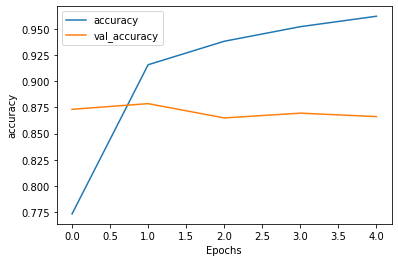

In [17]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy') # plot_graphs(history, 'loss')

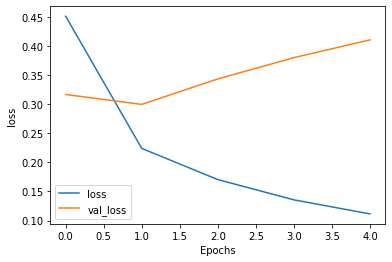

In [18]:
plot_graphs(history, 'loss')

In [19]:
model.evaluate(test_dataset, verbose = 1)

391/391 [==============================] - 7s 19ms/step - loss: 0.4106 - accuracy: 0.8662


[0.41061532497406006, 0.8662400245666504]

## GRU

In [20]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, 64, input_length=120),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, return_sequences = False)), 
    # only returns the last cell's output, which is why the output shape is (None, 64) and not (None, 120, 64)
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()
# After the bidirectional layer, each of the length 120 sequences 
# is mapped into 64-dimensional space which represents whether that sequence is positive or negative

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 64)           523840    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                18816     
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 390       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 7         
Total params: 543,053
Trainable params: 543,053
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
NUM_EPOCHS= 10
callback = tf.keras.callbacks.EarlyStopping(monitor= "val_loss", patience = 3, verbose = 1)
history = model.fit(train_dataset, epochs=NUM_EPOCHS, validation_data=test_dataset, callbacks = [callback])

Epoch 1/10
391/391 [==============================] - 196s 501ms/step - loss: 0.5693 - accuracy: 0.6971 - val_loss: 0.4833 - val_accuracy: 0.7825
Epoch 2/10
391/391 [==============================] - 177s 452ms/step - loss: 0.4021 - accuracy: 0.8294 - val_loss: 0.4178 - val_accuracy: 0.8261
Epoch 3/10
391/391 [==============================] - 168s 431ms/step - loss: 0.3428 - accuracy: 0.8612 - val_loss: 0.4414 - val_accuracy: 0.8135
Epoch 4/10
391/391 [==============================] - 165s 422ms/step - loss: 0.2489 - accuracy: 0.9062 - val_loss: 0.3911 - val_accuracy: 0.8461
Epoch 5/10
391/391 [==============================] - 174s 444ms/step - loss: 0.2035 - accuracy: 0.9273 - val_loss: 0.4497 - val_accuracy: 0.8339
Epoch 6/10
391/391 [==============================] - 165s 423ms/step - loss: 0.1697 - accuracy: 0.9387 - val_loss: 0.5030 - val_accuracy: 0.7616
Epoch 7/10
391/391 [==============================] - 168s 429ms/step - loss: 0.1365 - accuracy: 0.9526 - val_loss: 0.4653 -

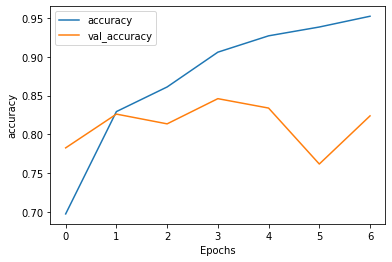

In [22]:
plot_graphs(history, 'accuracy')

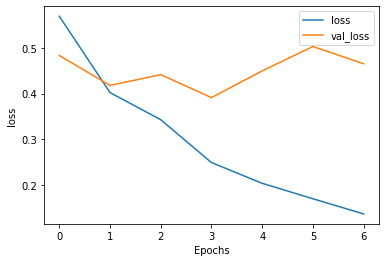

In [23]:
plot_graphs(history, 'loss')

In [24]:
model.evaluate(test_dataset, verbose = 1)

391/391 [==============================] - 62s 157ms/step - loss: 0.4653 - accuracy: 0.8238


[0.4653192162513733, 0.8238400220870972]